In [2]:
import os
from scipy import ndimage
import nibabel as nib
from keras.utils import get_file
import torchio as tio
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import random
import shutil

C:\Users\maxim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# THIS CODE IS NOW REDUNDANT THE FULL DATABASE CAN BE FOUND HERE : https://www.kaggle.com/datasets/mathurinache/mosmeddata-chest-ct-scans-with-covid19/data


# url_1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
# url_2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

# file_path = "c:\\Users\\maxim\\OneDrive\\Desktop\\Research\\Experiment_1\\datasets\\CT-0.zip"
# if os.path.exists(file_path):
#     os.remove(file_path)  # Deletes the incomplete file

# # Directory where the files will be stored
# cache_dir = os.getcwd()  # Current working directory

# # Download the first file
# filename_1 = get_file("CT-0.zip", url_1, cache_dir=cache_dir)

# # Download the second file
# filename_2 = get_file("CT-23.zip", url_2, cache_dir=cache_dir)

# # Make a directory to store the data
# os.makedirs("CT_Data", exist_ok=True)  # Using exist_ok=True to avoid errors if the directory exists

# # Unzip the first file
# with zipfile.ZipFile(filename_1, "r") as z_fp:
#     z_fp.extractall("./CT_Data/")

# # Unzip the second file
# with zipfile.ZipFile(filename_2, "r") as z_fp:
#     z_fp.extractall("./CT_Data/")

In [5]:
for dirpath, dirnames, filenames in os.walk("MosMedData"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'MosMedData'.
There are 0 directories and 172 images in 'MosMedData\CT-0'.
There are 0 directories and 172 images in 'MosMedData\CT-23'.


CT Scan Shape:  (512, 512, 45)


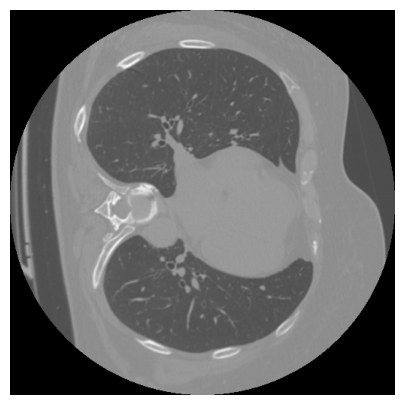

CT Scan Shape:  (512, 512, 43)


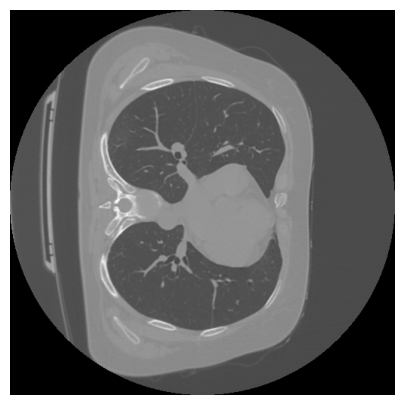

In [6]:
def plot_ct_scans_from_directory(study_dir):

        img = nib.load(study_dir)
        volume = img.get_fdata()

        print("CT Scan Shape: ", np.array(volume).shape)

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./MosMedData/CT-0/study_0150.nii"
study_directory_2 = "./MosMedData/CT-23/study_0975.nii"

plot_ct_scans_from_directory(study_directory)
plot_ct_scans_from_directory(study_directory_2)

In [7]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 50
    desired_width = 224
    desired_height = 224
    
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=3)
    return img

def process_scan(volume):
    """Read and resize volume"""

    volume = normalize(volume)
    volume = resize_volume(volume)
    
    return volume

In [8]:
def process_scans_in_directories():
    directories = ["./MosMedData/CT-0", "./MosMedData/CT-23"]

    for directory in directories:
        # Loop through each file in the directory
        for filename in os.listdir(directory):
            if filename.endswith(".nii"):
                nii_path = os.path.join(directory, filename)
                # Load the NIfTI image
                img = nib.load(nii_path)
                volume = img.get_fdata()

                # Process the scan
                processed_volume = process_scan(volume)

                # Save the processed volume back to the NIfTI file
                nib.save(nib.Nifti1Image(processed_volume, img.affine), nii_path)

# Call the function to process scans
process_scans_in_directories()

CT Scan Shape:  (224, 224, 50)


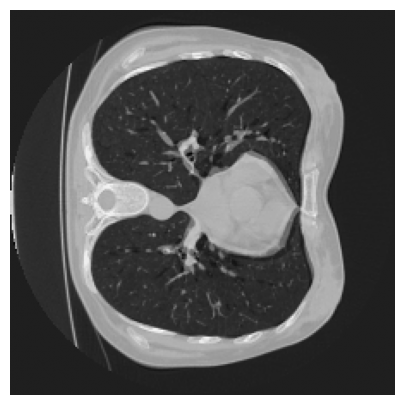

CT Scan Shape:  (224, 224, 50)


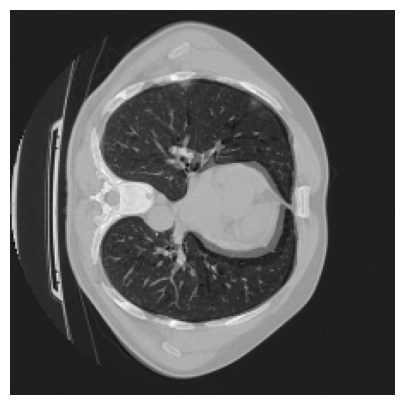

In [9]:
study_directory = "./MosMedData/CT-0/study_0172.nii"
study_directory_2 = "./MosMedData/CT-23/study_0986.nii"

plot_ct_scans_from_directory(study_directory)
plot_ct_scans_from_directory(study_directory_2)

In [10]:
augmentations = [
    tio.Compose([tio.RandomAffine(), tio.RandomGamma()]),
    tio.Compose([tio.RandomElasticDeformation(), tio.RandomNoise()]),
    tio.Compose([tio.RandomFlip(), tio.RandomBiasField()]),
    tio.Compose([tio.RandomAffine(), tio.RandomBlur()]),
    tio.Compose([tio.RandomGamma(), tio.RandomNoise()])
]

def augment_and_save(input_dir, output_dir, num_augments=5):
    """
    Augments .nii files from the input directory and saves them in the output directory.
    
    Args:
        input_dir (str): Path to the input directory with the original .nii files.
        output_dir (str): Path to the output directory where augmented files will be saved.
        num_augments (int): Number of augmentations to apply per file (default is 5).
    """
    # Make sure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate over all the subdirectories (e.g., CT-0, CT-1, etc.)
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.nii'):
                # Construct the full path to the current .nii file
                file_path = os.path.join(root, file)
                
                # Load the file as a TorchIO subject
                subject = tio.Subject(ct=tio.ScalarImage(file_path))
                
                # Create the directory structure in the output folder
                relative_path = os.path.relpath(root, input_dir)  # Get subfolder like 'CT-0'
                output_subdir = os.path.join(output_dir, relative_path, file.split('.')[0])  # e.g., Processed_CT/CT-0/study_001
                os.makedirs(output_subdir, exist_ok=True)
                
                # Save the original file in the output directory
                original_output_path = os.path.join(output_subdir, file)
                subject.ct.save(original_output_path)
                
                # Shuffle augmentations to ensure each version gets a distinct augmentation
                available_augmentations = augmentations.copy()
                random.shuffle(available_augmentations)  # Shuffle augmentations list
                
                # Apply augmentations and save the augmented files
                for i in range(num_augments):
                    aug = available_augmentations[i]  # Get a distinct augmentation from shuffled list
                    transformed = aug(subject)
                    
                    # Create a separate folder for each augmentation
                    aug_output_subdir = os.path.join(output_dir, relative_path, f"{file.split('.')[0]}_aug_{i+1}")
                    os.makedirs(aug_output_subdir, exist_ok=True)
                    
                    # Save the augmented file in the corresponding augmentation folder
                    augmented_file_name = f"{file.split('.')[0]}_aug_{i+1}.nii.gz"
                    augmented_output_path = os.path.join(aug_output_subdir, augmented_file_name)
                    transformed.ct.save(augmented_output_path)

                print(f"Processed {file} and saved augmented versions in {output_subdir}")

# Example usage
input_dir = 'MosMedData/CT-0'  # Replace with your input directory
output_dir = 'Processed_CT/CT-0'  # Replace with your desired output directory

augment_and_save(input_dir, output_dir)
augment_and_save("./MosMedData/CT-23", "./Processed_CT/CT-23")

Processed study_0001.nii and saved augmented versions in Processed_CT/CT-0\.\study_0001
Processed study_0002.nii and saved augmented versions in Processed_CT/CT-0\.\study_0002
Processed study_0003.nii and saved augmented versions in Processed_CT/CT-0\.\study_0003
Processed study_0004.nii and saved augmented versions in Processed_CT/CT-0\.\study_0004
Processed study_0005.nii and saved augmented versions in Processed_CT/CT-0\.\study_0005
Processed study_0006.nii and saved augmented versions in Processed_CT/CT-0\.\study_0006
Processed study_0007.nii and saved augmented versions in Processed_CT/CT-0\.\study_0007
Processed study_0008.nii and saved augmented versions in Processed_CT/CT-0\.\study_0008
Processed study_0009.nii and saved augmented versions in Processed_CT/CT-0\.\study_0009
Processed study_0010.nii and saved augmented versions in Processed_CT/CT-0\.\study_0010
Processed study_0011.nii and saved augmented versions in Processed_CT/CT-0\.\study_0011
Processed study_0012.nii and sav

In [17]:
import os
import nibabel as nib

def split_nii_files_to_structured_output(input_root):
    """
    Goes into Processed_CT/CT-x/study_xxxx/ folders,
    splits the .nii or .nii.gz file inside into two halves along the third axis,
    saves them as split_part_1.nii.gz and split_part_2.nii.gz, and deletes the original file.
    """

    for ct_class in os.listdir(input_root):
        ct_class_path = os.path.join(input_root, ct_class)
        if not os.path.isdir(ct_class_path):
            continue

        for study_folder in os.listdir(ct_class_path):
            study_path = os.path.join(ct_class_path, study_folder)
            if not os.path.isdir(study_path):
                continue

            # Look for .nii or .nii.gz file inside study folder
            nii_files = [f for f in os.listdir(study_path) if f.endswith(".nii") or f.endswith(".nii.gz")]
            if not nii_files:
                continue  # No scan file, skip

            nii_file = nii_files[0]  # Assuming only one scan per folder
            input_path = os.path.join(study_path, nii_file)

            # Load and split
            img = nib.load(input_path)
            data = img.get_fdata()
            affine = img.affine
            header = img.header

            mid = data.shape[2] // 2
            part1 = data[:, :, :mid]
            part2 = data[:, :, mid:]

            out1 = os.path.join(study_path, "split_part_1.nii.gz")
            out2 = os.path.join(study_path, "split_part_2.nii.gz")
            nib.save(nib.Nifti1Image(part1, affine, header), out1)
            nib.save(nib.Nifti1Image(part2, affine, header), out2)

            os.remove(input_path)

            print(f"Processed {input_path} -> split_part_1 & split_part_2")

# Example usage:
input_root = "Processed_CT"
split_nii_files_to_structured_output(input_root)


Processed Processed_CT\CT-0\study_0001\study_0001.nii -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0001_aug_1\study_0001_aug_1.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0001_aug_2\study_0001_aug_2.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0001_aug_3\study_0001_aug_3.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0001_aug_4\study_0001_aug_4.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0001_aug_5\study_0001_aug_5.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0002\study_0002.nii -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0002_aug_1\study_0002_aug_1.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0002_aug_2\study_0002_aug_2.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\study_0002_aug_3\study_0002_aug_3.nii.gz -> split_part_1 & split_part_2
Processed Processed_CT\CT-0\st

In [18]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Example usage:
path = "Processed_CT/CT-23"
path2 = "Processed_CT/CT-0"

print(f"Number of directories: {count_directories(path2)}")
print(f"Number of directories: {count_directories(path)}")

Number of directories: 1032
Number of directories: 1032


CT Scan Shape:  (224, 224, 25)


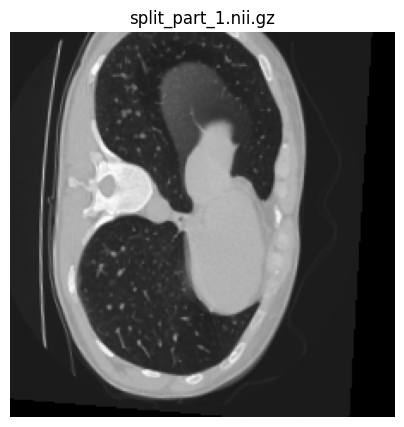

CT Scan Shape:  (224, 224, 25)


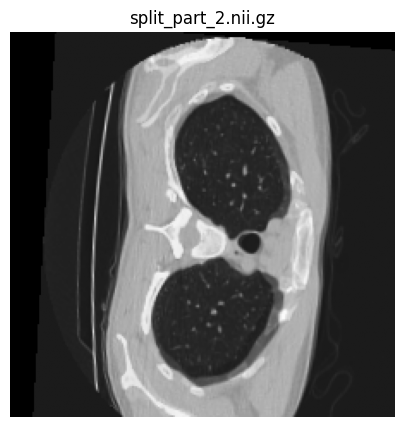

CT Scan Shape:  (224, 224, 25)


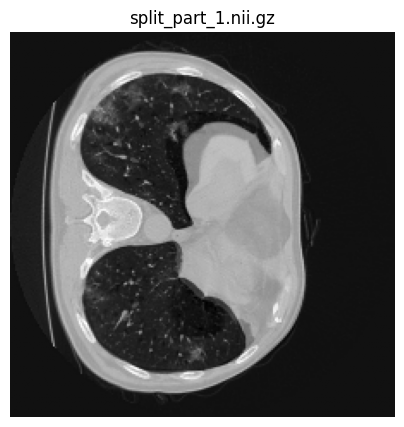

CT Scan Shape:  (224, 224, 25)


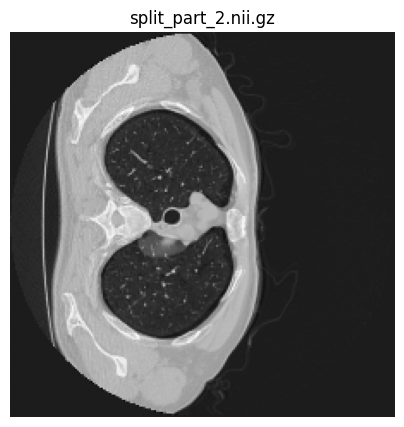

In [32]:
# Function to load and plot the NIfTI files from the specified directory
def plot_ct_scans_from_directory(study_dir):
    # Get all the .nii files in the directory
    nii_files = [f for f in os.listdir(study_dir) if f.endswith('.nii.gz')]
    
    # Plot each file
    for nii_file in nii_files:
        # Load the NIfTI file

        nii_path = os.path.join(study_dir, nii_file)
        img = nib.load(nii_path)
        volume = img.get_fdata()

        print("CT Scan Shape: ", np.array(volume).shape)

        # Plot the whole volume (using a max intensity projection)
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        axes.imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")  # Middle slice of the volume
        axes.set_title(nii_file)
        axes.axis('off')  # No axis for better visual
        plt.show()

study_directory = "./Processed_CT/CT-0/study_0090_aug_2"
plot_ct_scans_from_directory(study_directory)



study_directory = "./Processed_CT/CT-23/study_0965"
plot_ct_scans_from_directory(study_directory)

In [33]:
def split_train_test_by_aug_name(input_root, train_root="train", test_root="test"):
    """
    Splits the directories under Processed_CT/CT-x/ into train and test sets:
    - If the directory name contains 'aug', it's moved to train/CT-x/
    - Else, it's moved to test/CT-x/
    """

    for ct_class in os.listdir(input_root):
        ct_class_path = os.path.join(input_root, ct_class)
        if not os.path.isdir(ct_class_path):
            continue

        for study_folder in os.listdir(ct_class_path):
            study_path = os.path.join(ct_class_path, study_folder)
            if not os.path.isdir(study_path):
                continue

            # Determine if it's an augmented study or original
            if "aug" in study_folder.lower():
                target_base = train_root
            else:
                target_base = test_root

            target_dir = os.path.join(target_base, ct_class)
            os.makedirs(target_dir, exist_ok=True)

            new_path = os.path.join(target_dir, study_folder)
            shutil.move(study_path, new_path)
            print(f"Moved {study_folder} -> {target_dir}")

# Example usage:
split_train_test_by_aug_name("Processed_CT")

Moved study_0001 -> test\CT-0
Moved study_0001_aug_1 -> train\CT-0
Moved study_0001_aug_2 -> train\CT-0
Moved study_0001_aug_3 -> train\CT-0
Moved study_0001_aug_4 -> train\CT-0
Moved study_0001_aug_5 -> train\CT-0
Moved study_0002 -> test\CT-0
Moved study_0002_aug_1 -> train\CT-0
Moved study_0002_aug_2 -> train\CT-0
Moved study_0002_aug_3 -> train\CT-0
Moved study_0002_aug_4 -> train\CT-0
Moved study_0002_aug_5 -> train\CT-0
Moved study_0003 -> test\CT-0
Moved study_0003_aug_1 -> train\CT-0
Moved study_0003_aug_2 -> train\CT-0
Moved study_0003_aug_3 -> train\CT-0
Moved study_0003_aug_4 -> train\CT-0
Moved study_0003_aug_5 -> train\CT-0
Moved study_0004 -> test\CT-0
Moved study_0004_aug_1 -> train\CT-0
Moved study_0004_aug_2 -> train\CT-0
Moved study_0004_aug_3 -> train\CT-0
Moved study_0004_aug_4 -> train\CT-0
Moved study_0004_aug_5 -> train\CT-0
Moved study_0005 -> test\CT-0
Moved study_0005_aug_1 -> train\CT-0
Moved study_0005_aug_2 -> train\CT-0
Moved study_0005_aug_3 -> train\CT-0

In [36]:
path2 = "train/CT-0"
path = "train/CT-23"

path3 = "test/CT-0"
path4 = "test/CT-23"

print(f"Number of directories in train/CT-0: {count_directories(path2)}")
print(f"Number of directories in train/CT-23 : {count_directories(path)}")
print("\n")
print(f"Number of directories in test/CT-0: {count_directories(path3)}")
print(f"Number of directories in test/CT-23 : {count_directories(path4)}")

Number of directories in train/CT-0: 860
Number of directories in train/CT-23 : 860


Number of directories in test/CT-0: 172
Number of directories in test/CT-23 : 172
